# Convolutional Neural Networks with Intermediate Loss for 3D Super-Resolution of CT and MRI Scans

This notebook is a replication/exploration of the paper listed above.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import sys
sys.path.append('..') # Stupid thing Python makes you do to import from a sibling directory
from gen_utils.SrGen import SrGen # Custom class for image generation

## Define model

In [5]:
class CNNIL(nn.Module):
    def __init__(self, upscale=2, axs = 'hw'):
        super().__init__()
        self.axs = axs

        self.rel = nn.ReLU()
        if axs == 'hw':
            self.conv1 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv2 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv3 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv4 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv5 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv6 = nn.Conv2d(32,4,3, padding='same', bias=False)
            
            # Upscale step occurs here

            self.conv7 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv8 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv9 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv10 = nn.Conv2d(32,1,3, padding='same', bias = False)
        elif axs == 'h' or axs == 'w':
            self.conv1 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv2 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv3 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv4 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv5 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv6 = nn.Conv2d(32,2,3, padding='same', bias=False)
            
            # Upscale step occurs here

            self.conv7 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv8 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv9 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv10 = nn.Conv2d(32,1,3, padding='same', bias = False)

    def forward(self, x):

        x = self.rel(self.conv1(x))
        
        x_l = self.rel(self.conv2(x))
        x_l = self.rel(self.conv3(x_l))
        x_l = self.rel(self.conv4(x_l+x))
        x_l = self.rel(self.conv5(x_l))
        x_l = self.rel(self.conv6(x_l+x))

        x_l = self.kern_upscale(x_l, axs = self.axs)

        x = self.rel(self.conv7(x_l))
        x_h = self.rel(self.conv8(x))
        x_h = self.rel(self.conv9(x_h))
        x_h = self.rel(self.conv10(x_h+x))

        return x_l, x_h #Return both results for the loss function

    @staticmethod
    def kern_upscale(x, axs='hw'):
        # Function to do the unique upscaling pattern they propose in
        # the paper
        #TODO: have them input a tuple for scale of the dimensions they wish to expand along
        s, c, h, w = [int(_) for _ in list(x.shape)]

        if axs == 'hw':
            c = int(c/2)
            x_up = torch.cat(torch.unbind(x,1),2)
            x_up = torch.reshape(x_up,(s,1,h*c,w*c))
            x_up = torch.transpose(x_up,2,3)
            x_up = torch.cat(torch.split(x_up,2,2),3)
            x_up = torch.transpose(torch.reshape(x_up,(s,1,h*c,w*c)),2,3)
        elif axs == 'h':
            x_up = torch.unsqueeze(torch.cat(torch.unbind(x,2),1),1)
            #x_up = torch.unsqueeze(x_up,0)
        elif axs == 'w':
            x_up = torch.cat(torch.unbind(x,3),1)
            x_up = torch.unsqueeze(torch.transpose(x_up,1,2),1)
            #x_up = torch.unsqueeze(x_up,0)
        else:
            print('No valid scaling dimension selected, returning False')
            x_up = False

        return x_up


In [2]:
# Testing of kern_upscale function with only 3D tensor

a = torch.tensor([[[1,2],[3,4]],
                [[5,6],[7,8]],
                [[9,10],[11,12]],
                [[13,14],[15,16]]])
a.shape

torch.Size([4, 2, 2])

In [3]:
# Concatinate each of the layers next to eachother
print(a.shape)
b = torch.cat(torch.unbind(a),1)
print(b.shape)
b = torch.reshape(b,(4,4))
print(b.shape)
b = torch.transpose(b,0,1)
b = torch.cat(torch.split(b,2,0),1)
torch.transpose(torch.reshape(b,(4,4)),0,1)

torch.Size([4, 2, 2])
torch.Size([2, 8])
torch.Size([4, 4])


tensor([[ 1,  5,  2,  6],
        [ 9, 13, 10, 14],
        [ 3,  7,  4,  8],
        [11, 15, 12, 16]])

In [4]:
# Testing of above kern_upscale function with 4D tensor (what the model will acually use)
a = torch.tensor([[[[1,2],[3,4]],
                [[5,6],[7,8]],
                [[9,10],[11,12]],
                [[13,14],[15,16]]]])
print(f'shape of a is {a.shape}')

b = torch.cat(torch.unbind(a,1),2)
b = torch.reshape(b,(1,1,4,4))
b = torch.transpose(b,2,3)
b = torch.cat(torch.split(b,2,2),3)
b = torch.transpose(torch.reshape(b,(1,1,4,4)),2,3)
b

shape of a is torch.Size([1, 4, 2, 2])


tensor([[[[ 1,  5,  2,  6],
          [ 9, 13, 10, 14],
          [ 3,  7,  4,  8],
          [11, 15, 12, 16]]]])

In [13]:
# Upscale along just one axis
a = torch.tensor([[[[1,2],[3,4]],
                [[5,6],[7,8]]],[[[2,4],[6,8]],[[10,12],[14,16]]]])
print(f'shape of a is {a.shape}')

# Version for doubling height
# b = torch.cat(torch.unbind(a,2),2)
# b = torch.reshape(b,(1,1,2,4))
# b = torch.cat(torch.split(b,2,3),2)

## b = torch.unsqueeze(torch.cat(torch.unbind(a,2),1),0)

# Version for doubling width
b = torch.cat(torch.unbind(a,3),1)
torch.unsqueeze(torch.transpose(b, 1,2),1)

#b.shape

shape of a is torch.Size([2, 2, 2, 2])


tensor([[[[ 1,  5,  2,  6],
          [ 3,  7,  4,  8]]],


        [[[ 2, 10,  4, 12],
          [ 6, 14,  8, 16]]]])

## Set Optimization Parameters

In [14]:
net_1 = CNNIL(axs = 'hw')
net_2 = CNNIL(axs = 'w')

# "... trained the CNN for 40 epochs, starting with a learning rate of 0.001 and decreasing
# the learning rate to 0.0001 after the first 20 epochs"
optimizer_1 = optim.Adam(net_1.parameters(), lr=0.001)
optimizer_2 = optim.Adam(net_2.parameters(), lr=0.001)

# They have a custom loss function that incorporates the final results and the result
# right after the upscaling step
# https://discuss.pytorch.org/t/custom-loss-functions/29387

def intermediate_loss(output_intermediate, output_final, target):
    mae_loss = nn.L1Loss() #Built in mean absolute error loss function
    loss = mae_loss(output_intermediate, target)+mae_loss(output_final, target)
    return loss


## Generate Data for Training

In [7]:
sr_train_1 = SrGen('../data/CNNIL_nifti/Raw/','../data/CNNIL_nifti/HR_train_1/','../data/CNNIL_nifti/LR_train_1/')

temp = sr_train_1.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [2,2,1]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
temp['keep_blank'] = False
temp['same_size'] = False
temp['patch'] = [14,14,1] #[x,y,z] when looking at the brain from the top down
temp['step'] = [10,10,2]
sr_train_1.set_template(temp)

sr_train_1.run(clear=True, save=True)
# sr_train_1.match_altered(update=True, paths=False, sort=False)

Clearing existing output directories
(193, 256, 256)
[2, 2, 1]
shape of image = (192, 256, 256)
patch size = [14, 14, 1]
step size = [10, 10, 2]
patch guess = 57600
stack size = (57600, 14, 14, 1)
57599


14616it [00:13, 1080.45it/s]


Number of patches: 14616
Number of blank patches: 42984
shape of image = (96, 128, 256)
keeping blank
patch size = [7, 7, 1]
step size = [5, 5, 2]
patch guess = 57600
stack size = (57600, 7, 7, 1)
57599


14616it [00:13, 1066.56it/s]

Files processed successfully


In [8]:
sr_train_2 = SrGen('../data/CNNIL_nifti/Raw/','../data/CNNIL_nifti/HR_train_2/','../data/CNNIL_nifti/LR_train_2/')
temp = sr_train_2.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [1,1,2]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
# temp['scale']= [1,1,1]
temp['keep_blank'] = False
temp['same_size'] = False
temp['patch'] = [1,7,14] #[x,y,z] when looking at the brain from the top down
temp['step'] = [2,20,20]
sr_train_2.set_template(temp)

sr_train_2.run(clear=True, save=True)
#sr_train_2.match_altered(update=True, paths=False, sort=False)

Clearing existing output directories
(193, 256, 256)
[1, 1, 2]
shape of image = (193, 256, 256)
patch size = [1, 7, 14]
step size = [2, 20, 20]
patch guess = 16393
stack size = (16393, 1, 7, 14)
16392


3728it [00:03, 1080.43it/s]


Number of patches: 3728
Number of blank patches: 12665
shape of image = (193, 256, 128)
keeping blank
patch size = [1, 7, 7]
step size = [2, 20, 10]
patch guess = 16393
stack size = (16393, 1, 7, 7)
16392


3728it [00:03, 979.89it/s] 

Files processed successfully


# Create Dataloader

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sr_class, axs='hw'):
        self.sr_class = sr_class
        self.axs = axs

        # In case I forget to run match_altered before pulling the class
        if not sr_class.HR_files:
            sr_class.match_altered(update=True)

    def __len__(self):
        return len(self.sr_class.HR_files)

    def __getitem__(self, index):
        Y, X = self.sr_class.load_image_pair(index)

        # SR along two axes
        if self.axs == 'hw':
            X = torch.unsqueeze(torch.squeeze(torch.tensor(X, dtype=torch.float32),-1),0)
            Y = torch.unsqueeze(torch.squeeze(torch.tensor(Y, dtype=torch.float32),-1),0)

        # SR along one axis
        elif self.axs == 'h':
            X = torch.squeeze(torch.tensor(X, dtype=torch.float32),-1)
            Y = torch.squeeze(torch.tensor(Y, dtype=torch.float32),-1)
        elif self.axs == 'w':
            raise NotImplementedError('Super resolution along width not currently supported')
        else:
            raise NotImplementedError(f'Super resolution along {self.axs} currently not supported')
            
        return X,Y

In [12]:
params = {'batch_size': 128,
        'shuffle': True,
        'num_workers': 3}

training_set_1 = Dataset(sr_train_1, axs = 'hw')
training_generator_1 = torch.utils.data.DataLoader(training_set_1, **params)


training_set_2 = Dataset(sr_train_2, axs = 'h')
training_generator_2 = torch.utils.data.DataLoader(training_set_2, **params)

# Training Loop

In [15]:
from tqdm import tqdm
import time

max_epochs = 15
save_rate = 10
epoch_adjust = 0
save_prefix = "./CNNIL_save_"

mean_loss = {'CNNIL_1': [],
            'CNNIL_2':[]}

for epoch in tqdm(range(max_epochs)):
    losses = []

    # Training
    count = 0
    for inp, goal in training_generator_1:
        optimizer_1.zero_grad()

        output_1, output_2 = net_1(inp) # the 2 is the number of iterations in the LISTA network
        #output = torch.clamp(output, 0, 255)

        loss = intermediate_loss(output_1,output_2,goal)
        loss.backward()
        optimizer_1.step()
        #print(f'loss = {loss.item()}')
        losses.append(loss.item())
        count = count+1
    

    # if (epoch % save_rate == 0) or epoch == (max_epochs-1):
    #     torch.save(net.state_dict(), f'{save_prefix}{epoch+epoch_adjust}.p')
    print(f'CNNIL_1 : epoch {epoch}, loss mean: {sum(losses)/len(losses)}, loss: {min(losses)}-{max(losses)}')
    mean_loss["CNNIL_1"].append(sum(losses)/len(losses))

    # Give computer time to cool down
    time.sleep(10)


for epoch in tqdm(range(max_epochs)):
    losses = []

    # Training
    count = 0
    for inp, goal in training_generator_2:
        optimizer_2.zero_grad()

        output_1, output_2 = net_2(inp) # the 2 is the number of iterations in the LISTA network
        #output = torch.clamp(output, 0, 255)

        loss = intermediate_loss(output_1,output_2,goal)
        loss.backward()
        optimizer_2.step()
        #print(f'loss = {loss.item()}')
        losses.append(loss.item())
        count = count+1
    

    # if (epoch % save_rate == 0) or epoch == (max_epochs-1):
    #     torch.save(net.state_dict(), f'{save_prefix}{epoch+epoch_adjust}.p')
    print(f'CNNIL_2 : epoch {epoch}, loss mean: {sum(losses)/len(losses)}, loss: {min(losses)}-{max(losses)}')
    mean_loss["CNNIL_2"].append(sum(losses)/len(losses))

    # Give computer time to cool down
    time.sleep(10)


  0%|          | 0/15 [00:00<?, ?it/s]

CNNIL_1 : epoch 0, loss mean: 39.683535882701044, loss: 25.732463836669922-125.50652313232422


  7%|▋         | 1/15 [00:18<04:21, 18.68s/it]

CNNIL_1 : epoch 1, loss mean: 21.140986085974653, loss: 16.00338363647461-27.926010131835938


 13%|█▎        | 2/15 [00:38<04:09, 19.18s/it]

CNNIL_1 : epoch 2, loss mean: 15.241460219673488, loss: 11.922856330871582-18.2259578704834


 20%|██        | 3/15 [00:57<03:51, 19.33s/it]

CNNIL_1 : epoch 3, loss mean: 12.714632084058678, loss: 10.790395736694336-14.660911560058594


 27%|██▋       | 4/15 [01:17<03:33, 19.45s/it]

CNNIL_1 : epoch 4, loss mean: 11.583752117986265, loss: 9.758451461791992-14.127046585083008


 33%|███▎      | 5/15 [01:40<03:27, 20.79s/it]

CNNIL_1 : epoch 5, loss mean: 10.670327858302905, loss: 9.081177711486816-12.263397216796875


 40%|████      | 6/15 [01:59<03:03, 20.34s/it]

CNNIL_1 : epoch 6, loss mean: 10.074368352475373, loss: 8.855419158935547-11.703458786010742


 47%|████▋     | 7/15 [02:20<02:43, 20.49s/it]

CNNIL_1 : epoch 7, loss mean: 9.610449144114618, loss: 8.563833236694336-11.503731727600098


 53%|█████▎    | 8/15 [02:40<02:22, 20.35s/it]

CNNIL_1 : epoch 8, loss mean: 9.09516892640487, loss: 8.153694152832031-10.472452163696289


 60%|██████    | 9/15 [03:00<02:01, 20.27s/it]

CNNIL_1 : epoch 9, loss mean: 8.946892754927925, loss: 7.788918495178223-10.219636917114258


 67%|██████▋   | 10/15 [03:20<01:40, 20.19s/it]

CNNIL_1 : epoch 10, loss mean: 8.557588212386422, loss: 7.583730220794678-9.512673377990723


 73%|███████▎  | 11/15 [03:42<01:22, 20.66s/it]

CNNIL_1 : epoch 11, loss mean: 8.416303149513576, loss: 7.361637115478516-9.685577392578125


 80%|████████  | 12/15 [04:04<01:02, 20.89s/it]

CNNIL_1 : epoch 12, loss mean: 8.456875237174657, loss: 7.399376392364502-11.131046295166016


 87%|████████▋ | 13/15 [04:24<00:41, 20.63s/it]

CNNIL_1 : epoch 13, loss mean: 8.305838945637579, loss: 7.235193252563477-9.894247055053711


 93%|█████████▎| 14/15 [04:47<00:21, 21.36s/it]

CNNIL_1 : epoch 14, loss mean: 7.883763238658076, loss: 7.069115161895752-8.801149368286133


  0%|          | 0/15 [00:00<?, ?it/s]

CNNIL_2 : epoch 0, loss mean: 55.53704388936361, loss: 35.535560607910156-112.98587799072266


  7%|▋         | 1/15 [00:12<02:51, 12.25s/it]

CNNIL_2 : epoch 1, loss mean: 24.76580721537272, loss: 17.449665069580078-35.51130676269531


 13%|█▎        | 2/15 [00:24<02:38, 12.18s/it]

CNNIL_2 : epoch 2, loss mean: 13.96442855199178, loss: 11.258182525634766-17.751529693603516


 20%|██        | 3/15 [00:36<02:26, 12.17s/it]

CNNIL_2 : epoch 3, loss mean: 10.330316416422527, loss: 8.516886711120605-11.893511772155762


 27%|██▋       | 4/15 [00:48<02:13, 12.18s/it]

CNNIL_2 : epoch 4, loss mean: 8.475923347473145, loss: 7.364401817321777-10.016525268554688


 33%|███▎      | 5/15 [01:00<02:01, 12.13s/it]

CNNIL_2 : epoch 5, loss mean: 7.510581827163696, loss: 6.540799140930176-8.315034866333008


 40%|████      | 6/15 [01:12<01:49, 12.13s/it]

CNNIL_2 : epoch 6, loss mean: 6.978345966339111, loss: 6.124776840209961-7.899375915527344


 47%|████▋     | 7/15 [01:24<01:36, 12.12s/it]

CNNIL_2 : epoch 7, loss mean: 6.498832273483276, loss: 5.253299713134766-7.203611373901367


 53%|█████▎    | 8/15 [01:37<01:24, 12.14s/it]

CNNIL_2 : epoch 8, loss mean: 6.447013266881307, loss: 5.573140621185303-7.4939985275268555


 60%|██████    | 9/15 [01:50<01:14, 12.49s/it]

CNNIL_2 : epoch 9, loss mean: 6.101349290211996, loss: 5.331014633178711-6.848033905029297


 67%|██████▋   | 10/15 [02:03<01:02, 12.53s/it]

CNNIL_2 : epoch 10, loss mean: 5.9397130330403645, loss: 5.364993095397949-6.554086685180664


 73%|███████▎  | 11/15 [02:15<00:50, 12.54s/it]

CNNIL_2 : epoch 11, loss mean: 5.838910881678263, loss: 4.960616111755371-6.642794609069824


 80%|████████  | 12/15 [02:28<00:37, 12.54s/it]

CNNIL_2 : epoch 12, loss mean: 6.006017080942789, loss: 5.472186088562012-6.903541088104248


 87%|████████▋ | 13/15 [02:41<00:25, 12.82s/it]

CNNIL_2 : epoch 13, loss mean: 6.923411083221436, loss: 4.3185858726501465-9.001203536987305


 93%|█████████▎| 14/15 [02:55<00:13, 13.24s/it]

CNNIL_2 : epoch 14, loss mean: 5.9070786794026695, loss: 5.139086723327637-7.809691429138184


100%|██████████| 15/15 [03:09<00:00, 12.66s/it]


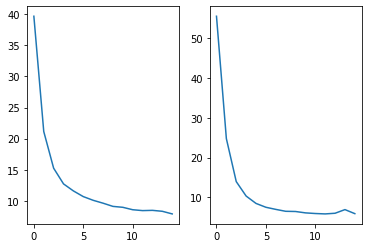

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
axs[0].plot([x for x in range(len(mean_loss["CNNIL_1"]))],mean_loss["CNNIL_1"])
axs[1].plot([x for x in range(len(mean_loss["CNNIL_1"]))],mean_loss["CNNIL_2"])

## Testing Model

In [22]:
# Generate testing data for both axes
sr_test_1 = SrGen('../data/CNNIL_nifti/Raw_test/','../data/CNNIL_nifti/HR_test_1/','../data/CNNIL_nifti/LR_test_1/')

temp = sr_test_1.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [2,2,1]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
temp['keep_blank'] = False
temp['same_size'] = False
temp['patch'] = [14,14,1] #[x,y,z] when looking at the brain from the top down
temp['step'] = [10,10,2]
sr_test_1.set_template(temp)

sr_test_1.run(clear=True, save=True)
#sr_test_1.match_altered(update=True, paths=False, sort=False)


sr_test_2 = SrGen('../data/CNNIL_nifti/Raw_test/','../data/CNNIL_nifti/HR_test_2/','../data/CNNIL_nifti/LR_test_2/')
temp = sr_test_2.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [1,1,2]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
# temp['scale']= [1,1,1]
temp['keep_blank'] = False
temp['same_size'] = False
temp['patch'] = [1,7,14] #[x,y,z] when looking at the brain from the top down
temp['step'] = [2,20,20]
sr_test_2.set_template(temp)

sr_test_2.run(clear=True, save=True)
#sr_test_2.match_altered(update=True, paths=False, sort=False)


Clearing existing output directories
(193, 256, 256)
[2, 2, 1]
shape of image = (192, 256, 256)
patch size = [14, 14, 1]
step size = [10, 10, 2]
patch guess = 57600
stack size = (57600, 14, 14, 1)
57599


15052it [00:13, 1144.85it/s]


Number of patches: 15052
Number of blank patches: 42548
shape of image = (96, 128, 256)
keeping blank
patch size = [7, 7, 1]
step size = [5, 5, 2]
patch guess = 57600
stack size = (57600, 7, 7, 1)
57599


15052it [00:17, 865.78it/s] 


Files processed successfully
Clearing existing output directories
(193, 256, 256)
[1, 1, 2]
shape of image = (193, 256, 256)
patch size = [1, 7, 14]
step size = [2, 20, 20]
patch guess = 16393
stack size = (16393, 1, 7, 14)
16392


3871it [00:05, 703.29it/s]


Number of patches: 3871
Number of blank patches: 12522
shape of image = (193, 256, 128)
keeping blank
patch size = [1, 7, 7]
step size = [2, 20, 10]
patch guess = 16393
stack size = (16393, 1, 7, 7)
16392


3871it [00:04, 817.89it/s] 

Files processed successfully


In [27]:
params_t = {'batch_size': 1,
        'shuffle': False,
        'num_workers': 3}

testing_set_1 = Dataset(sr_test_1, axs = 'hw')
testing_generator_1 = torch.utils.data.DataLoader(testing_set_1, **params_t)


testing_set_2 = Dataset(sr_train_2, axs = 'h')
testing_generator_2 = torch.utils.data.DataLoader(testing_set_2, **params_t)

#### Run both datasets through the model


In [36]:
from skimage.transform import resize
# Load trained models:
#net_1.load_state_dict(torch.load('./MRI_reflect_pad_save_39.p'))


with torch.no_grad():
    comp={'psnr' : [], 'rmse' : []}
    for idx, [im_l, im_h] in enumerate(testing_generator_1):

        # Take low resolution and upscale using bicubic interpolation
        # (which has already been done due to the image generation process)
        # Thus im_l is the bicubic interpolation to compare to...

        # Use SR model on low resolution image
        output_1, output_2 = net_1(im_l)

        # Upscale im_l to the same size as im_h
        im_l = torch.tensor(resize(im_l, im_h.shape, order=1, mode = 'symmetric'))

        # Calculate PSNR for bicubic
        # im_l = np.rint( np.clip(im_l, 0, 255))
        # im_h = np.rint( np.clip(im_h, 0, 255))
        diff = im_l - im_h
        rmse_b = np.sqrt((diff**2).mean())
        psnr_b = 20*np.log10(im_h.max()/rmse_b)

        #print(f'bicubic evaluation for {idx}: rms={rmse_b}, psnr={psnr_b}')

        # Calculate PSNR for SR
        # im_h_sr = np.rint( np.clip(im_h_sr, 0, 255))
        # im_h = np.rint( np.clip(im_h, 0, 255))
        diff = output_2 - im_h
        rmse_s = np.sqrt((diff**2).mean())
        psnr_s = 20*np.log10(im_h.max()/rmse_s)
        #print(f'SR evaluation for {idx}: rms={rmse_s}, psnr={psnr_s}')
        comp['psnr'].append(psnr_s-psnr_b)
        comp['rmse'].append(rmse_s-rmse_b)


HR and LR file locations updated


Text(0.5, 1.0, 'RMSE: SR - BiC')

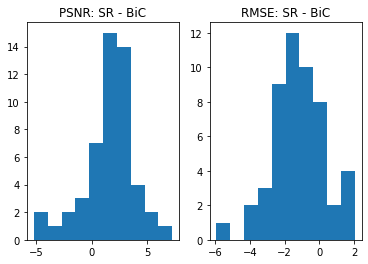

In [59]:
# Sanity check, plot a histogram of how well the SR image performed compared to the Bicubic comparison
fig, axs = plt.subplots(1, 2)
axs[0].hist([float(x) for x in comp['psnr'][0:-1:300]], bins=10)
axs[0].set_title('PSNR: SR - BiC')
axs[1].hist([float(x) for x in comp['rmse'][0:-1:300]], bins=10)
axs[1].set_title('RMSE: SR - BiC')

In [60]:
# Load trained models:
#net_1.load_state_dict(torch.load('./MRI_reflect_pad_save_39.p'))


with torch.no_grad():
    comp={'psnr' : [], 'rmse' : []}
    for idx, [im_l, im_h] in enumerate(testing_generator_2):

        # Use SR model on low resolution image
        output_1, output_2 = net_2(im_l)

        # Upscale im_l to the same size as im_h
        im_l = torch.tensor(resize(im_l, im_h.shape, order=1, mode = 'symmetric'))

        # Calculate PSNR for bicubic
        # im_l = np.rint( np.clip(im_l, 0, 255))
        # im_h = np.rint( np.clip(im_h, 0, 255))
        diff = im_l - im_h
        rmse_b = np.sqrt((diff**2).mean())
        psnr_b = 20*np.log10(im_h.max()/rmse_b)

        #print(f'bicubic evaluation for {idx}: rms={rmse_b}, psnr={psnr_b}')

        # Calculate PSNR for SR
        # im_h_sr = np.rint( np.clip(im_h_sr, 0, 255))
        # im_h = np.rint( np.clip(im_h, 0, 255))
        diff = output_2 - im_h
        rmse_s = np.sqrt((diff**2).mean())
        psnr_s = 20*np.log10(im_h.max()/rmse_s)
        #print(f'SR evaluation for {idx}: rms={rmse_s}, psnr={psnr_s}')
        comp['psnr'].append(psnr_s-psnr_b)
        comp['rmse'].append(rmse_s-rmse_b)


Text(0.5, 1.0, 'RMSE: SR - BiC')

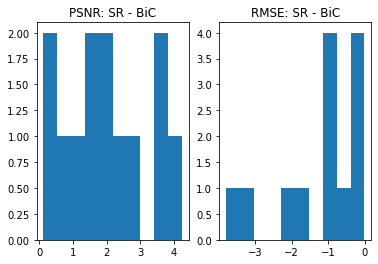

In [61]:
# Sanity check, plot a histogram of how well the SR image performed compared to the Bicubic comparison
fig, axs = plt.subplots(1, 2)
axs[0].hist([float(x) for x in comp['psnr'][0:-1:300]], bins=10)
axs[0].set_title('PSNR: SR - BiC')
axs[1].hist([float(x) for x in comp['rmse'][0:-1:300]], bins=10)
axs[1].set_title('RMSE: SR - BiC')

# Final Application

This is where I test both models on a full MRI image and see how it performs

- [ ] Create dataset of slightly altered full MRI `.nii` files
- [ ] Load saved trained models
- [ ] Compare to simple binomial interpolation (PSNR)


In [ ]:
# Generate testing data for both axes
sr = SrGen('../data/CNNIL_nifti/Raw_test/','../data/CNNIL_nifti/Full_test/','../data/CNNIL_nifti/Full_test/')

temp = sr.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [2,2,2]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
temp['keep_blank'] = False
temp['same_size'] = False

sr.set_template(temp)

# sr_train.run(clear=True, save=True)
sr.match_altered(update=True, paths=False, sort=False)

In [ ]:
# Run on full image:
# Load matched images
im_hr, im_lr = sr.match_altered(update = True, paths=True)

# Load trained models:
net_1.load_state_dict(torch.load('./MRI_reflect_pad_save_39.p'))
net_2.load_state_dict(torch.load('./MRI_reflect_pad_save_39.p'))


with torch.no_grad():
    for i in im_hr: #range(len(im_hr)):

        # Load in image information
        im_h, im_l = sr.load_image_pair(i)

        # Take low resolution and upscale using bicubic interpolation
        # (which has already been done due to the image generation process)
        # Thus im_l is the bicubic interpolation to compare to...

        # Use SR model on low resolution image
        im_h_sr = net(torch.unsqueeze(torch.unsqueeze(torch.tensor(im_l, dtype=torch.float32),0),0),2)

        # Calculate PSNR for bicubic
        # im_l = np.rint( np.clip(im_l, 0, 255))
        # im_h = np.rint( np.clip(im_h, 0, 255))
        diff = im_l - im_h
        rmse = np.sqrt((diff**2).mean())
        psnr = 20*np.log10(np.max(im_h)/rmse)

        print(f'bicubic evaluation for {i}: rms={rmse}, psnr={psnr}')

        # Calculate PSNR for SR
        # im_h_sr = np.rint( np.clip(im_h_sr, 0, 255))
        # im_h = np.rint( np.clip(im_h, 0, 255))
        diff = im_h_sr - im_h
        rmse = np.sqrt((diff**2).mean())
        psnr = 20*np.log10(np.max(im_h)/rmse)
        print(f'SR evaluation for {i}: rms={rmse}, psnr={psnr}')

        # if save_pred:
        #     img_name = os.path.splitext(os.path.basename(i))[0]
        #     Image.fromarray(np.rint(im_h_sr).astype(np.uint8)).save(f"{save_dir}/{img_name}_SR.png")
